# 0_read_data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 35) ## 생략 없이 한 번에 띄울 피쳐수 = 35
import warnings
warnings.filterwarnings('ignore')
from my_func import *

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font",family="Malgun Gothic") ## 폰트       한글 깨짐
plt.rc("axes",unicode_minus=False)    ## 폰트 minus 부호 깨짐
plt.style.use("ggplot")

df1 = pd.read_parquet( "data\df1.parquet" )
df3 = pd.read_parquet( "data\df3.parquet" )

def sp():
    print(f"     {df1.shape[0]:,} x {df1.shape[1]}          {df3.shape[0]:,} x {df3.shape[1]}")
    display(df1.head(1))
    display(df3.head(1))
sp()

     5,623,810 x 23          544,921 x 31


,id,age,man,push,frgn,birth,sign,buy,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,buy_cut,buy_y,buy_m,buy_d,buy_7,cnt_b
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,9,43000,35000,0,8000,8000,0.0,18.6,18.6,2019-08-01,2019,8,1,3,1


,id,age,man,push,frgn,birth,sign,sign_cut,sign_y,sign_m,sign_d,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,2019,8,25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,0,1,0,0,0,1,0,0,0,0


In [2]:
### df1, df3 시계열 추출 피쳐, 상업코드 피쳐 삭제
df1 = df1[['id', 'age', 'man', 'push', 'frgn', 'birth', 'sign', 'buy', 'buy_cut', 'm_id', 'pre', 'post', 'c_back', 'dscnt', 'total', 'c_back_R', 'dscnt_R', 'total_R', 'cnt_b']]
df3 = df3[['id', 'age', 'man', 'push', 'frgn', 'birth', 'sign', 'sign_cut', 'pre', 'post', 'c_back', 'dscnt', 'total', 'c_back_R', 'dscnt_R', 'total_R', 'cnt_p', 'cnt_b']]
sp()

     5,623,810 x 19          544,921 x 18


,id,age,man,push,frgn,birth,sign,buy,buy_cut,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_b
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,2019-08-01,9,43000,35000,0,8000,8000,0.0,18.6,18.6,1


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2


# 1_보따리상 정의
- 매출과 관련한 큰 손 유저 중에서
- 명확하게 구분되는 특정한 패턴 존재? ---> 군집 가능 (특성 찾아보자)

### 1_같은날, 동일가격상품을 반복 결제
- 이런 경우가 흔한가?

In [3]:
### 압축(groupby): 동일인물, 동일일자, 동일금액 기준

data = df1[["id","buy_cut","pre","cnt_b"]]
data = data.rename(columns={"cnt_b":"repeat"})
data = data.groupby(["id","buy_cut","pre"]).sum()
data

### 각 유저별 반복구매 범위: 1 <= repeat <= 자신의구매횟수

repeat
id     buy_cut    pre          
1      2019-08-25 10110       1
       2019-08-27 14220       1
2      2019-08-09 13530       1
       2019-10-15 11500       1
3      2019-08-24 18120       1
...                         ...
544921 2019-12-05 12900       1
       2019-12-14 15900       1
       2019-12-28 13900       1
       2020-01-12 11900       1
       2020-03-29 45200       1

[5425334 rows x 1 columns]

In [4]:
infox(data[["repeat"]])
### 전체 평균 반복구매 ---> 1.03 회

◆◆◆ (5425334, 1): Total shape ◆◆◆
---(5425334, 1): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype  n_uniq  |   Mean     Std  |max-min|  │  min  Q1  median  Q3  max  
 0  repeat     0      0.0  int64      35  |  1.037  0.2574         62  │    1   1       1   1   63  
------------------------------------------------------------------------------ 



In [5]:
### id, repeat 만 남긴다 
temp = data.reset_index().drop(["buy_cut","pre"],axis=1)
display(temp.head(3))

### 전체거래의 3.5% 만 repeat --> 반복구매에 해당된다.
print(round(100 - 100*temp.shape[0]/len(df1),1))

,id,repeat
0,1,1
1,1,1
2,2,1


3.5


In [6]:
temp1 = temp.groupby("id").max().reset_index()  # temp1: 유저별 반복구매 최대 횟수
temp1 = temp1.rename(columns={"repeat":"RP_max"})

temp2 = temp.groupby("id").mean().reset_index() # temp2: 유저별 반복구매 평균 횟수
temp2["repeat"] = round(temp2["repeat"],2)
temp2 = temp2.rename(columns={"repeat":"RP_mean"})

df3 = pd.merge( df3, temp1, how="left", on="id" )
df3 = pd.merge( df3, temp2, how="left", on="id" )
display(df3.head(3))

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.0


In [7]:
### max=63 / mean=14
infox(df3[["RP_max","RP_mean"]])

◆◆◆ (544921, 2): Total shape ◆◆◆
---(544921, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |   Mean     Std  |max-min|  │  min  Q1  median  Q3  max  
 0   RP_max     0      0.0    int64      34  |  1.172  0.5701         62  │    1   1       1   1   63  
 1  RP_mean     0      0.0  float64     238  |  1.032  0.1634         13  │    1   1       1   1   14  
------------------------------------------------------------------------------ 



In [8]:
### 하루에 63번 반복구매한 유저
display(df3.loc[df3.RP_max==63])

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


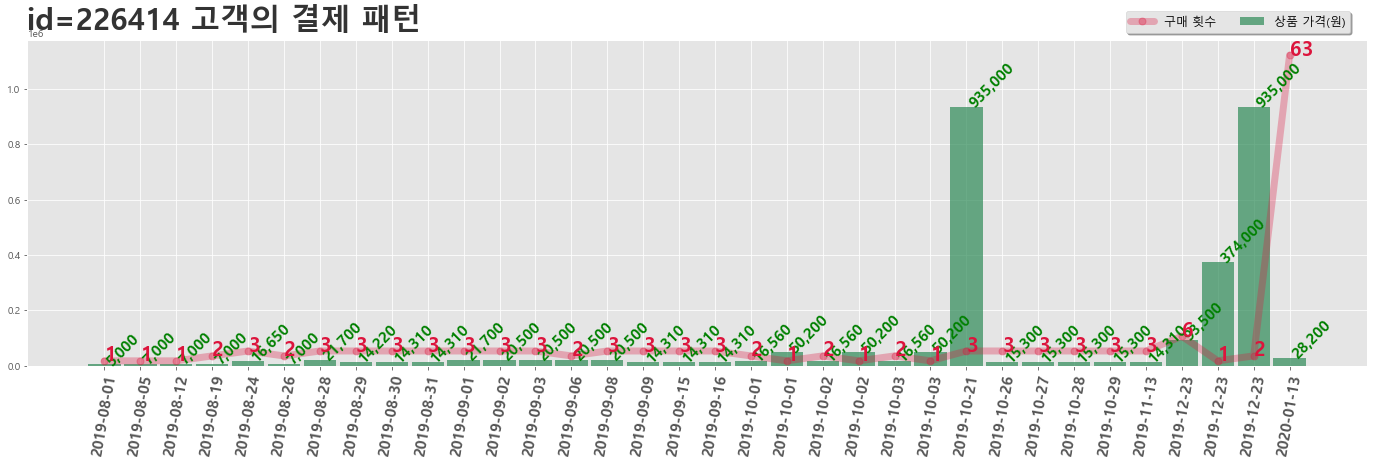

In [9]:
### 유저 반복결제 pattern 파악하는 함수
def patt(id):
    display(df3.loc[df3.id==id])
    df = df1.set_index("id")
    df = df.loc[id,["buy_cut","pre"]]
    df["repeat"] = 1
    df = df.groupby(["buy_cut","pre"]).sum().reset_index()
    
    N, max_pre, max_RP = len(df), np.max(df.pre), np.max(df.repeat)
    x,y1,y2 = range(N), df.pre, df.repeat.apply(lambda x:x*(1.2*max_pre//max_RP)) #---- 2개 그래프 한 판에 겹치려고..
    x_name = df.buy_cut.astype(str) #-------------------------------------------------- x축 눈금 값
    y1_value = df.pre.apply(lambda x:f"{x:,}") #--------------------------------------- 결제금액 콤마 처리

    plt.figure(figsize=((24,6)))
    plt.bar(x, y1, color="SeaGreen", alpha=0.7, width=0.9, label="상품 가격(원)", )
    plt.plot(x, y2, color="Crimson", label="구매 횟수", alpha=0.3, ls="-", linewidth=7, marker='o', ms=7, mfc="Crimson", solid_capstyle='round', )

    for i in range(N):
        plt.text(x[i],y1[i],y1_value[i], size=15, color="Green", weight=1000, rotation=45)
        plt.text(x[i],y2[i],df.repeat[i], size=20, color="Crimson", weight=1000,  )
        
    plt.title(f"id={id} 고객의 결제 패턴", weight=1000, color="k", size=30, alpha=0.8, pad=10, loc="left", )
    plt.xticks(x, x_name, fontsize=15, rotation=80, weight=1000, )
    plt.legend(loc=(0.82,1.02), fontsize=12, ncol=2, frameon=True, shadow=True, )
    plt.show()
    
patt(226414)

In [10]:
### 반복결제 평균이 14인 유저
display(df3.loc[df3.RP_mean==14])

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


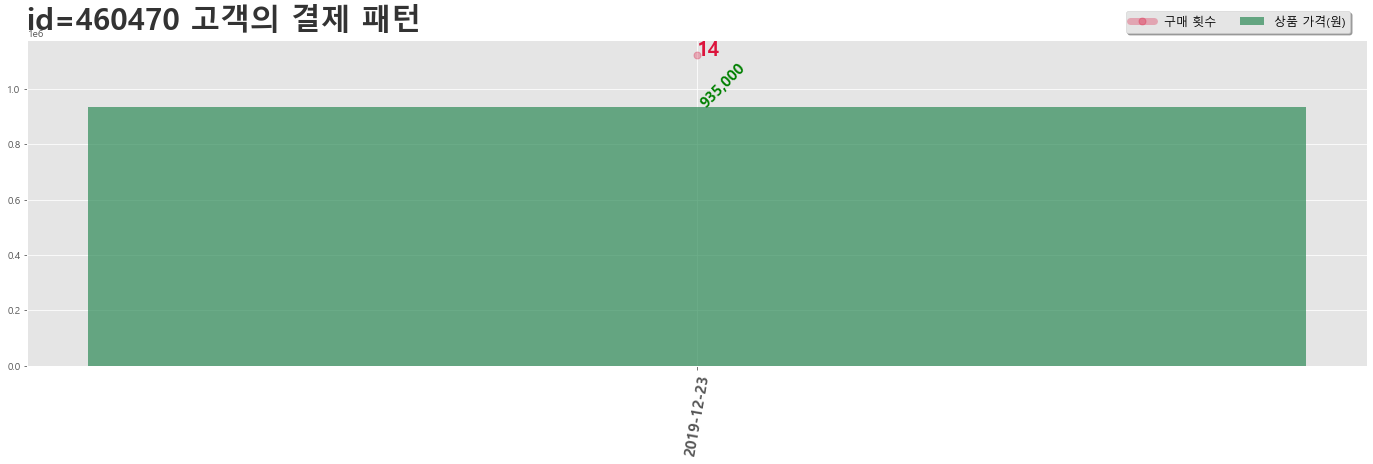

In [11]:
patt(460470)

In [12]:
### 반복결제 최댓값 상위 20명과,
### 반복결제 평균   상위 20명의 패턴 파악 해보자.
case1 = list(df3.sort_values(by="RP_max",ascending=False).head(10).id)
case2 = list(df3.sort_values(by="RP_mean",ascending=False).head(10).id)
case = case1 + case2
print(len(case)) #--------- (심지어 한 명은 겹친다..)

20


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


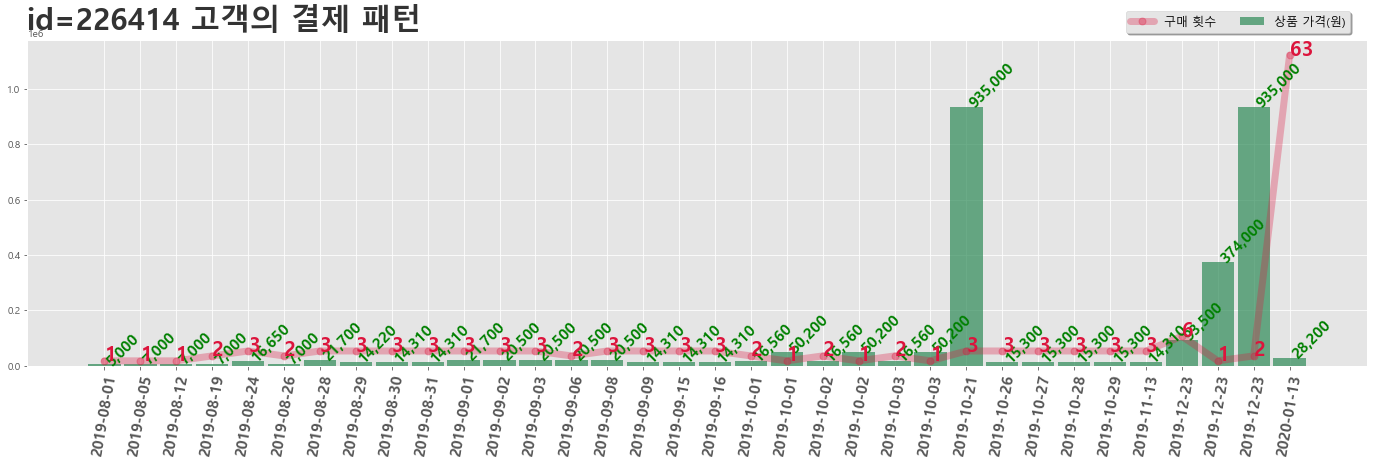

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
96993,96994,40,1,1,0,1981-02-19,2019-10-31 11:01:09.327,2019-10-31,2784113,2738095,80659,46018,126677,2.9,1.7,4.5,1,160,59,2.32


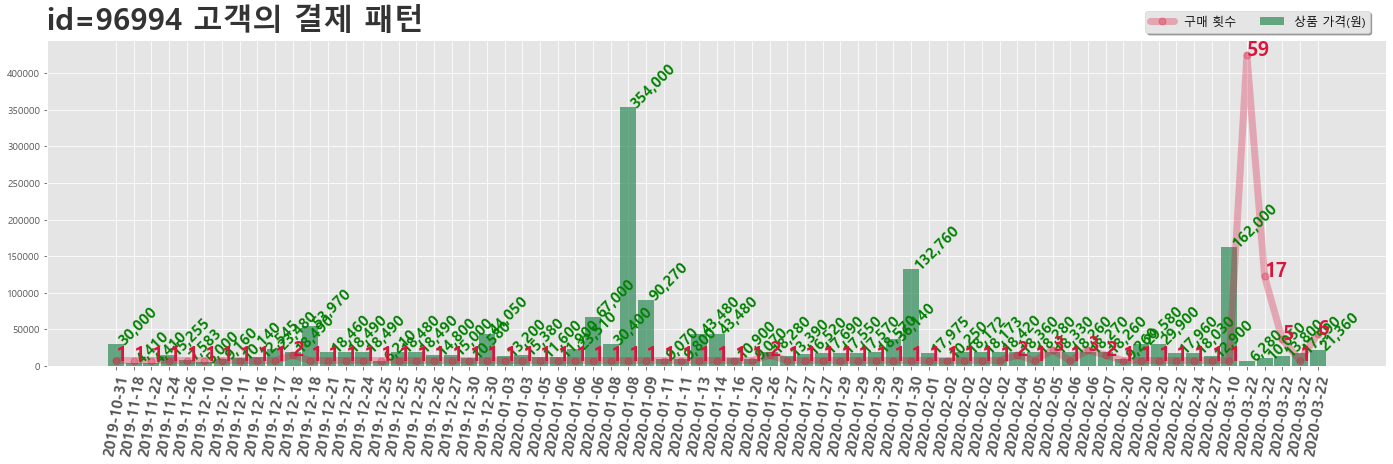

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
498861,498862,28,0,1,1,1993-09-06,2019-11-28 10:55:01.076,2019-11-28,17430846,17242586,52943,188260,241203,0.3,1.1,1.4,1,1013,44,2.58


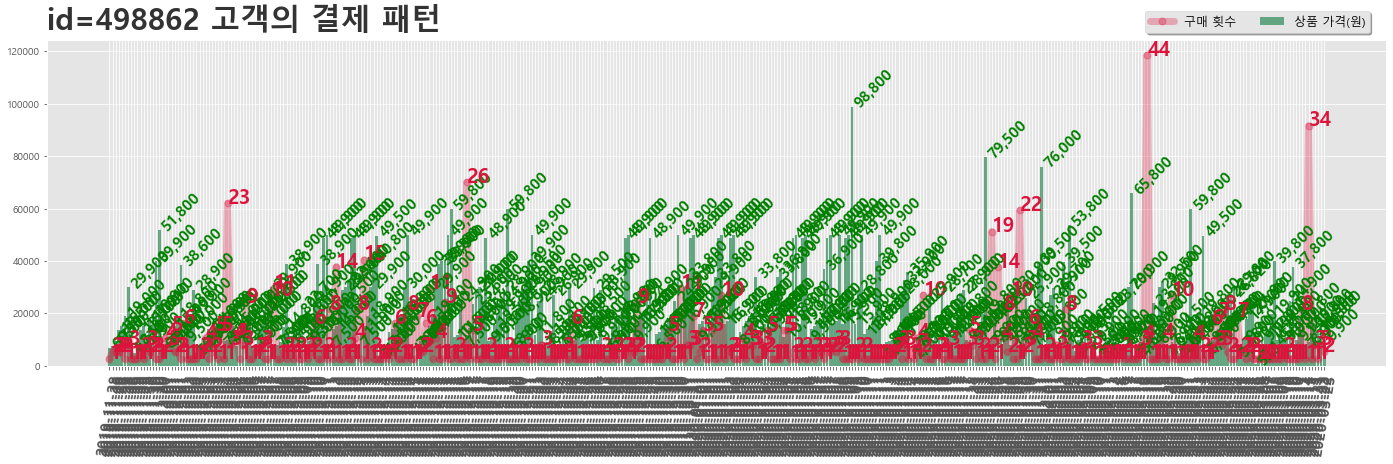

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
305343,305344,51,1,1,0,1970-12-15,2019-07-22 12:01:37.126,2019-07-22,1196630,1108760,0,87870,87870,0.0,7.3,7.3,1,59,34,5.36


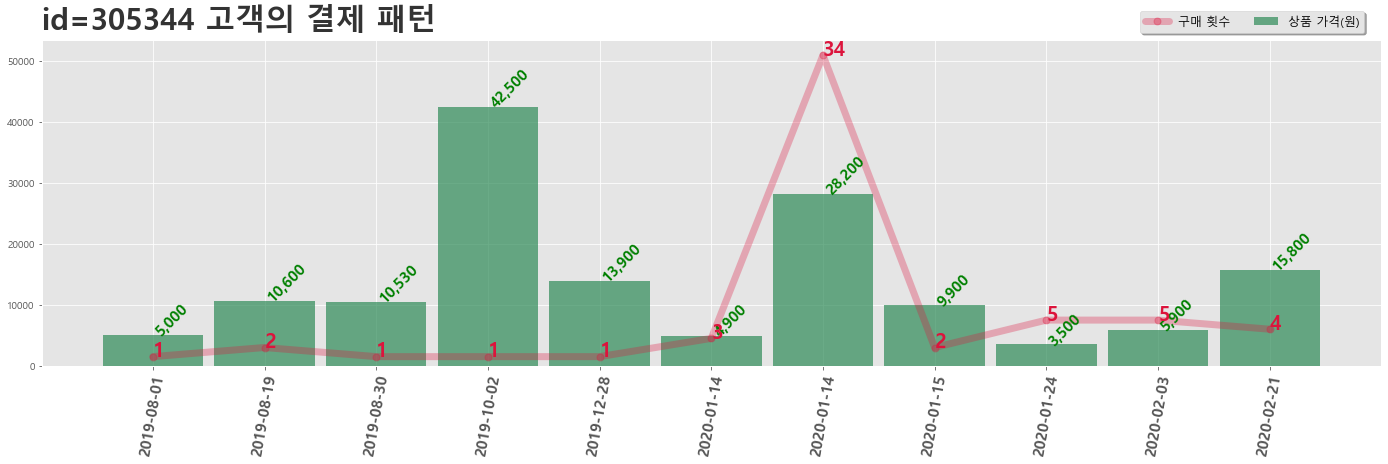

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
12198,12199,37,1,1,0,1984-07-03,2019-10-28 01:08:05.992,2019-10-28,1260087,1238167,39115,21920,61035,3.1,1.7,4.8,1,59,33,2.27


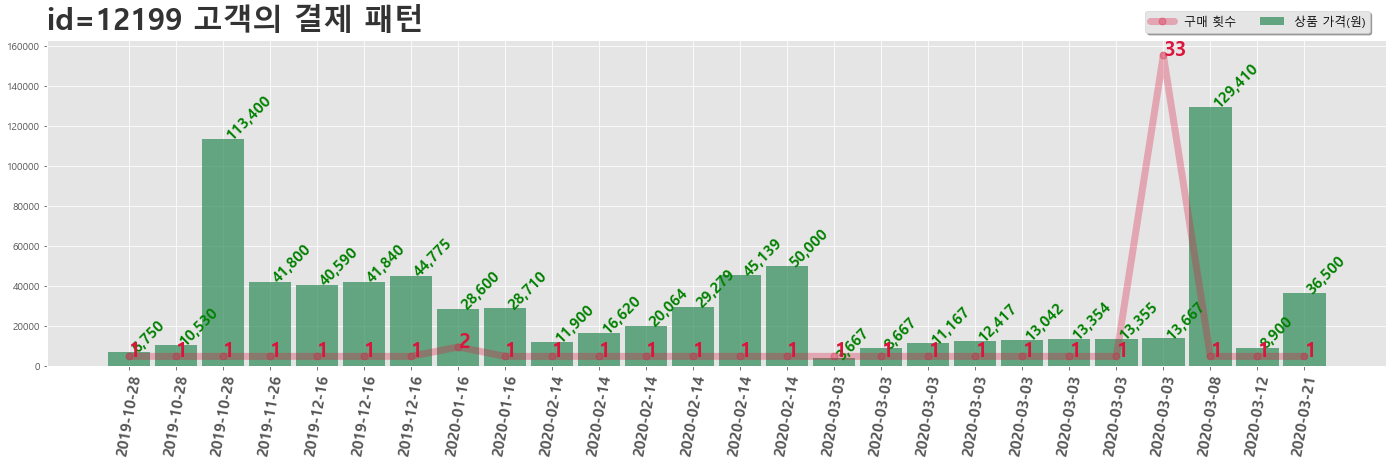

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
214909,214910,29,0,1,0,1992-10-04,2019-10-22 16:30:59.596,2019-10-22,1509140,1438379,16050,70761,86811,1.1,4.7,5.8,1,120,32,1.64


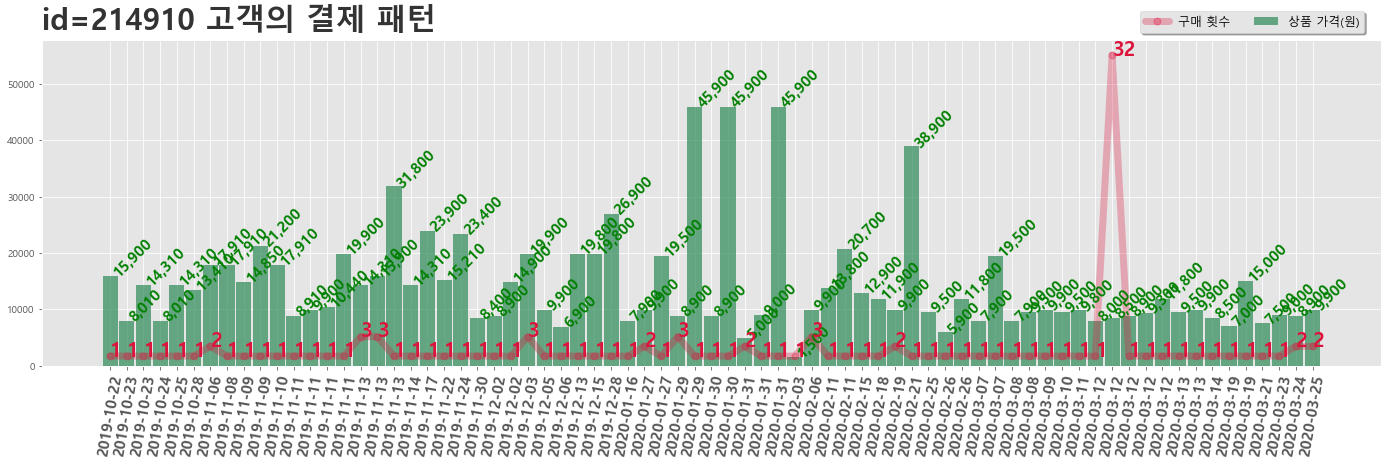

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
49507,49508,30,1,0,0,1991-04-02,2019-07-29 07:54:41.180,2019-07-29,6265130,5975359,354,289771,290125,0.0,4.6,4.6,1,99,30,1.9


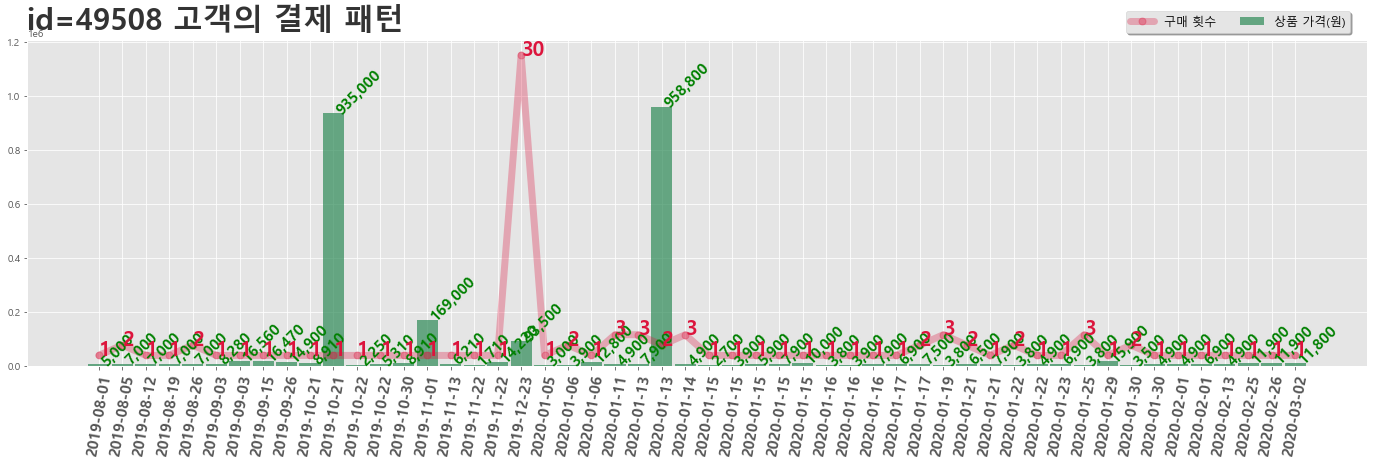

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
126683,126684,41,0,1,0,1980-02-24,2019-06-17 01:17:52.118,2019-06-17,1214937,1113787,9278,101150,110428,0.8,8.3,9.1,1,128,29,1.91


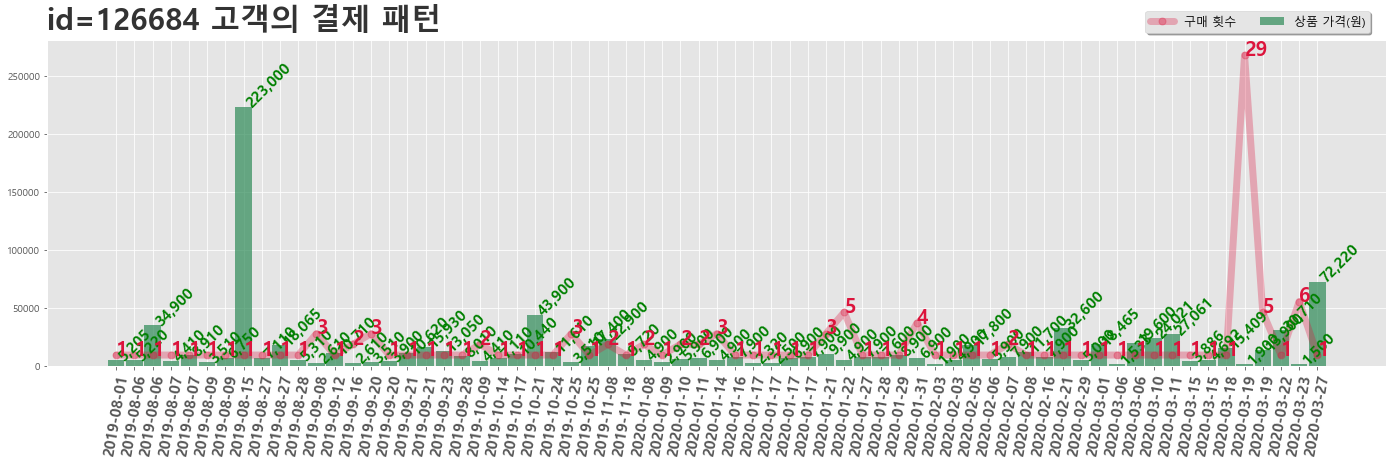

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
59561,59562,45,0,1,0,1976-04-20,2019-08-01 07:14:12.182,2019-08-01,3114802,2989047,0,125755,125755,0.0,4.0,4.0,1,74,28,3.52


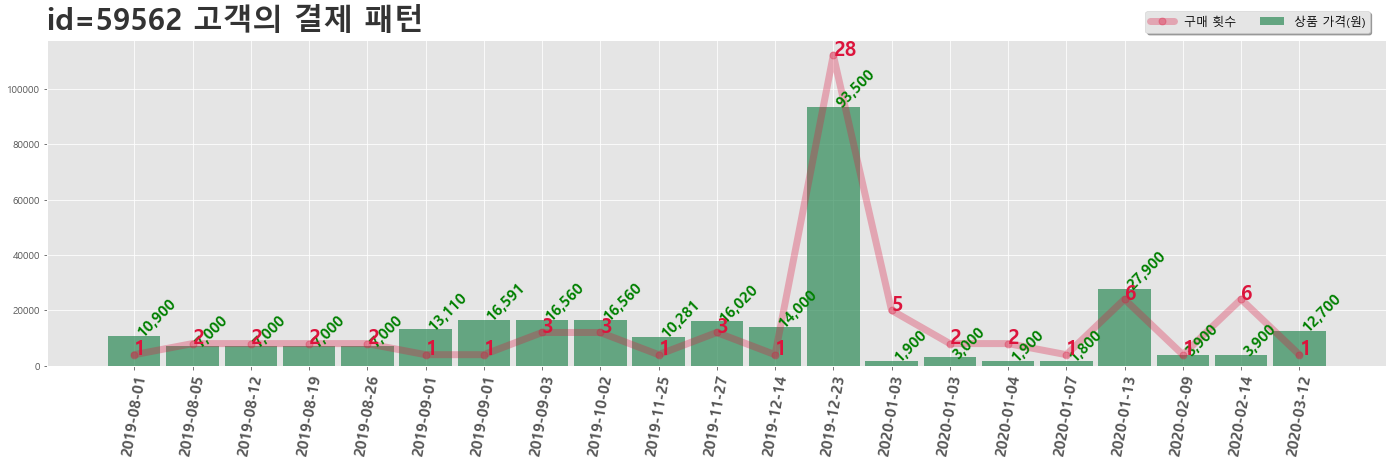

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
96305,96306,29,0,1,1,1992-12-29,2019-11-17 07:35:46.262,2019-11-17,15070935,14838387,222934,232548,455482,1.5,1.5,3.0,1,1229,25,1.92


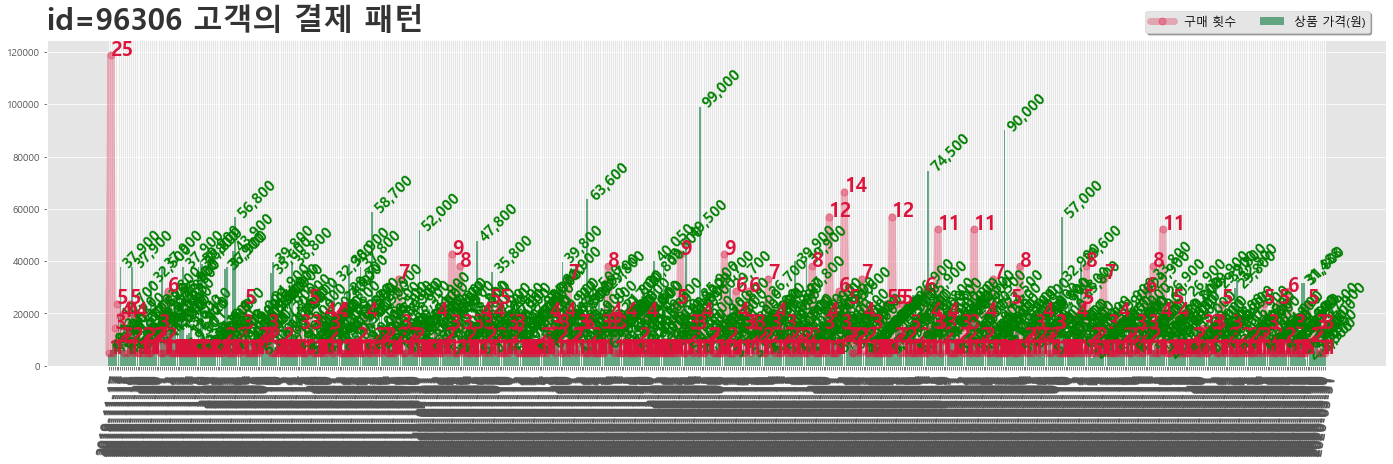

In [13]:
### 반복결제 최댓값 상위 20명
for i in case1:
    patt(i)

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


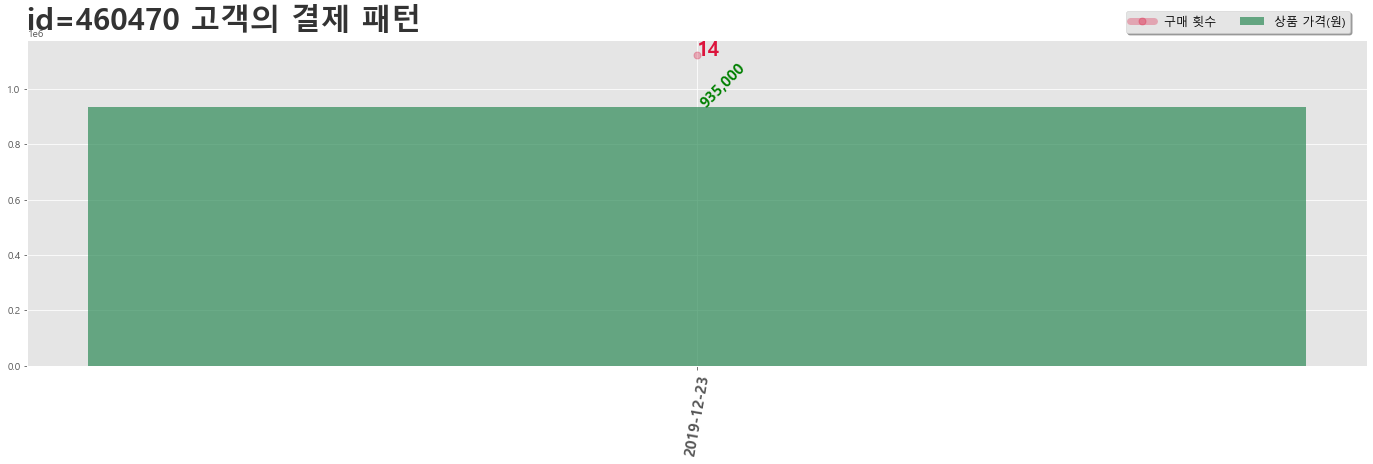

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
356378,356379,33,1,0,0,1988-02-09,2019-12-23 12:01:48.306,2019-12-23,6077500,5947500,0,130000,130000,0.0,2.1,2.1,1,45,25,11.25


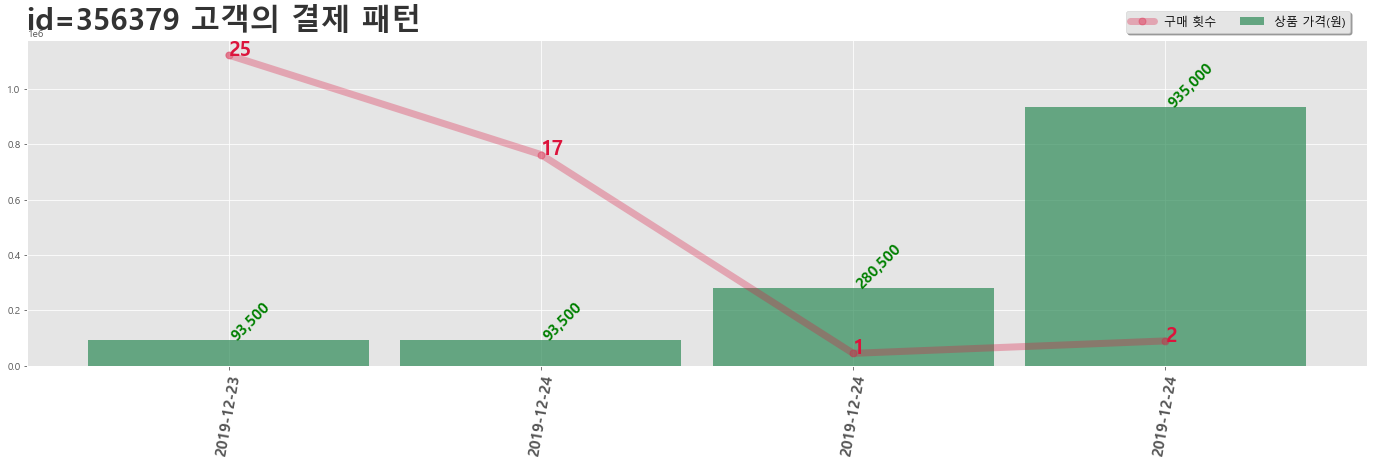

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
302746,302747,39,1,1,0,1982-07-26,2020-01-14 01:56:57.603,2020-01-14,574210,552210,510,22000,22510,0.1,3.8,3.9,1,21,20,10.5


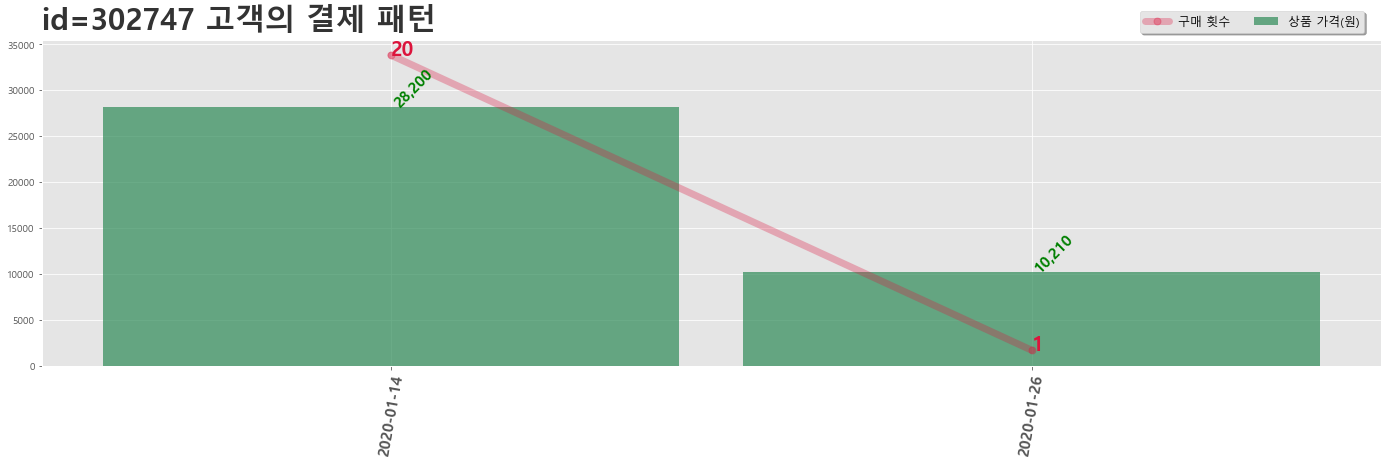

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
411488,411489,37,0,0,0,1984-09-05,2019-12-24 12:35:03.036,2019-12-24,1875000,1830000,0,45000,45000,0.0,2.4,2.4,1,21,20,10.5


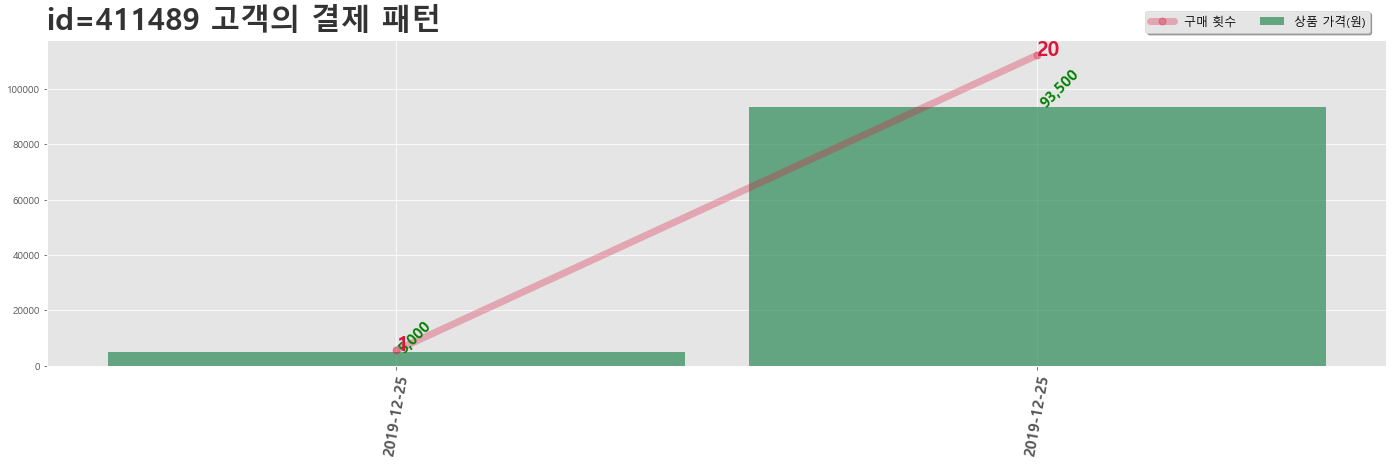

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
442192,442193,40,1,1,0,1981-12-11,2020-01-13 16:51:43.617,2020-01-13,282000,271500,0,10500,10500,0.0,3.7,3.7,1,10,10,10.0


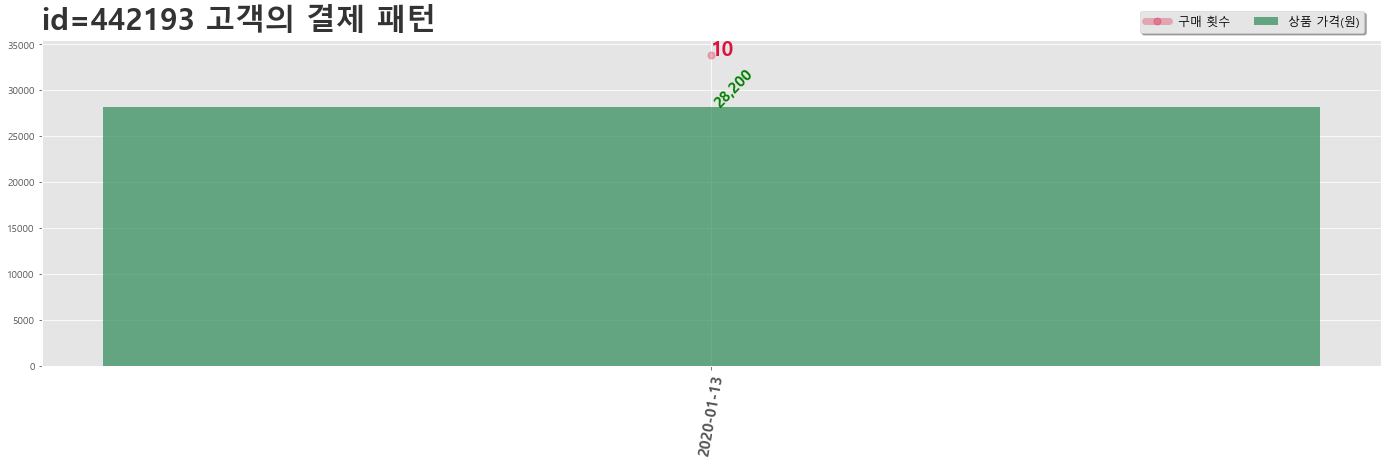

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
73439,73440,44,0,0,0,1977-12-14,2019-06-24 10:02:12.286,2019-06-24,935000,915000,0,20000,20000,0.0,2.1,2.1,1,10,10,10.0


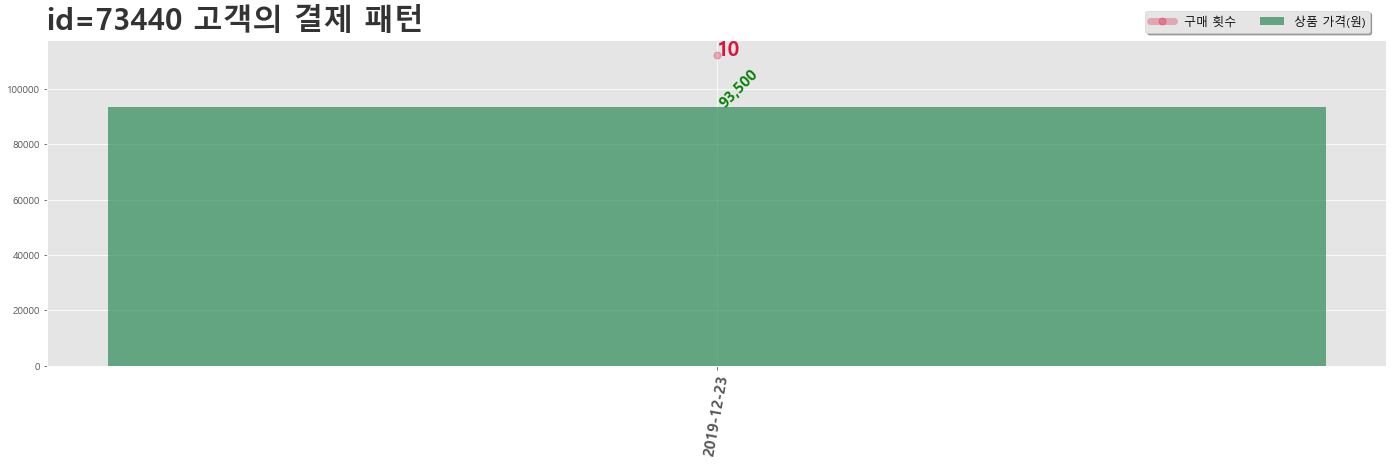

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
431511,431512,27,0,1,0,1994-05-18,2019-10-21 13:21:26.324,2019-10-21,935000,905000,0,30000,30000,0.0,3.2,3.2,1,10,10,10.0


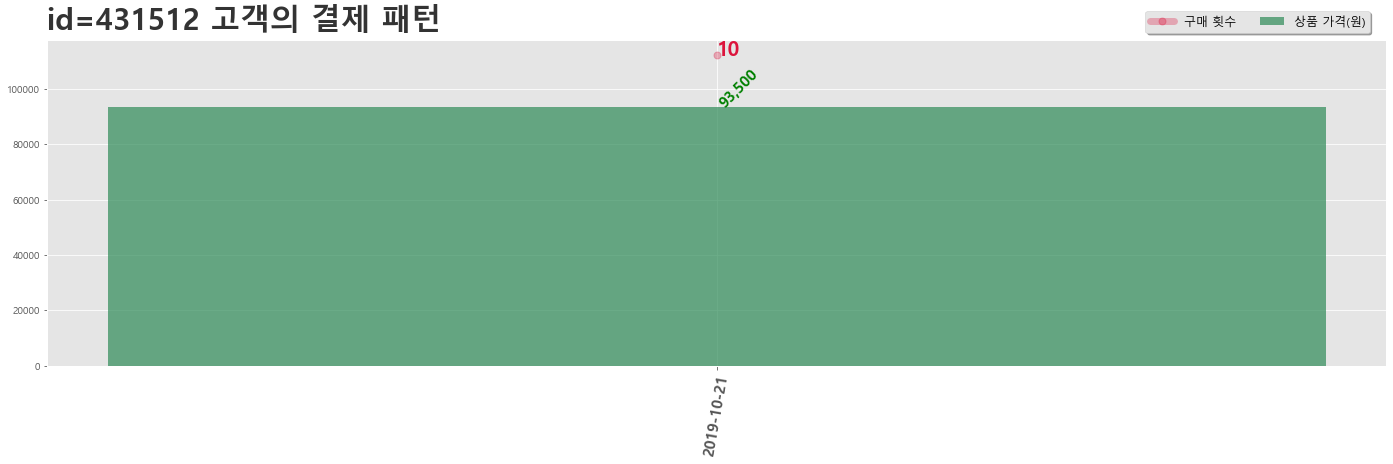

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
244745,244746,40,1,0,0,1981-10-22,2019-07-01 08:27:08.153,2019-07-01,935000,915000,0,20000,20000,0.0,2.1,2.1,1,10,10,10.0


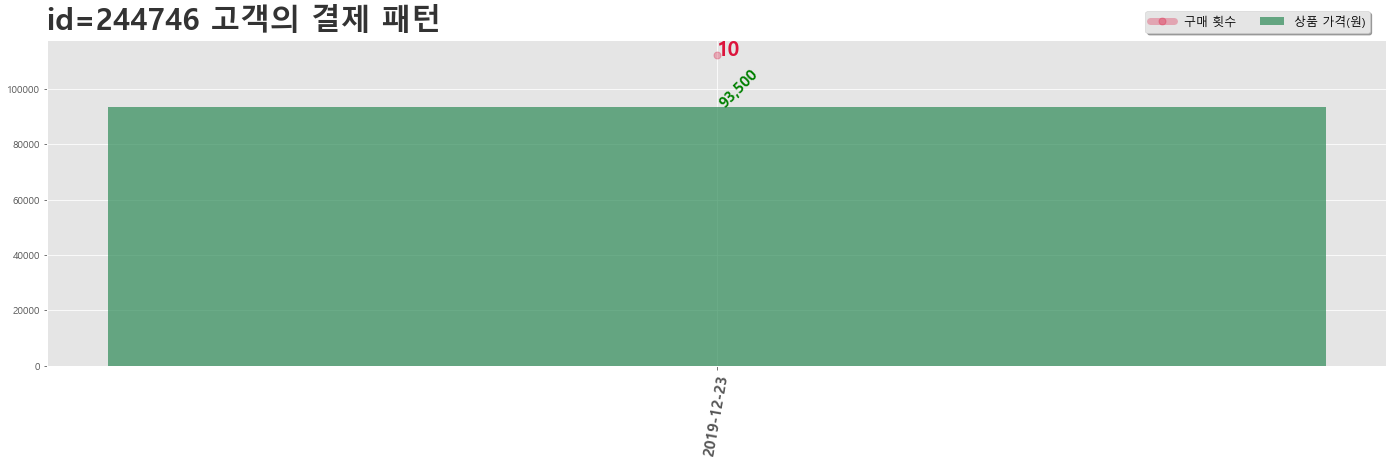

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
141567,141568,34,1,1,0,1987-05-28,2020-01-13 21:12:14.610,2020-01-13,282000,271500,0,10500,10500,0.0,3.7,3.7,1,10,10,10.0


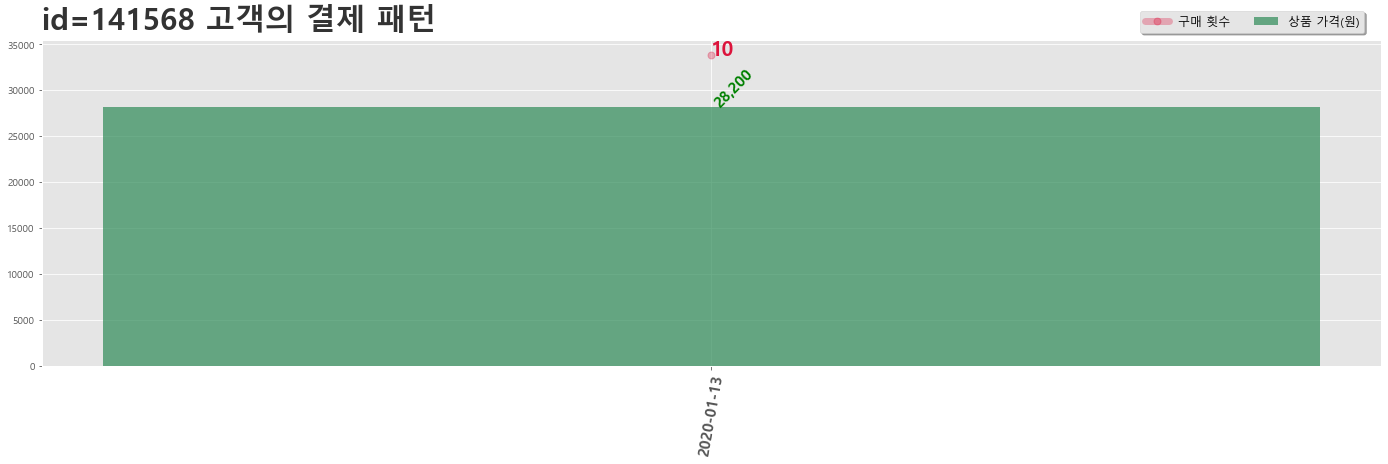

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
507979,507980,37,1,0,0,1984-04-29,2020-01-12 02:08:21.135,2020-01-12,282000,273000,0,9000,9000,0.0,3.2,3.2,1,10,10,10.0


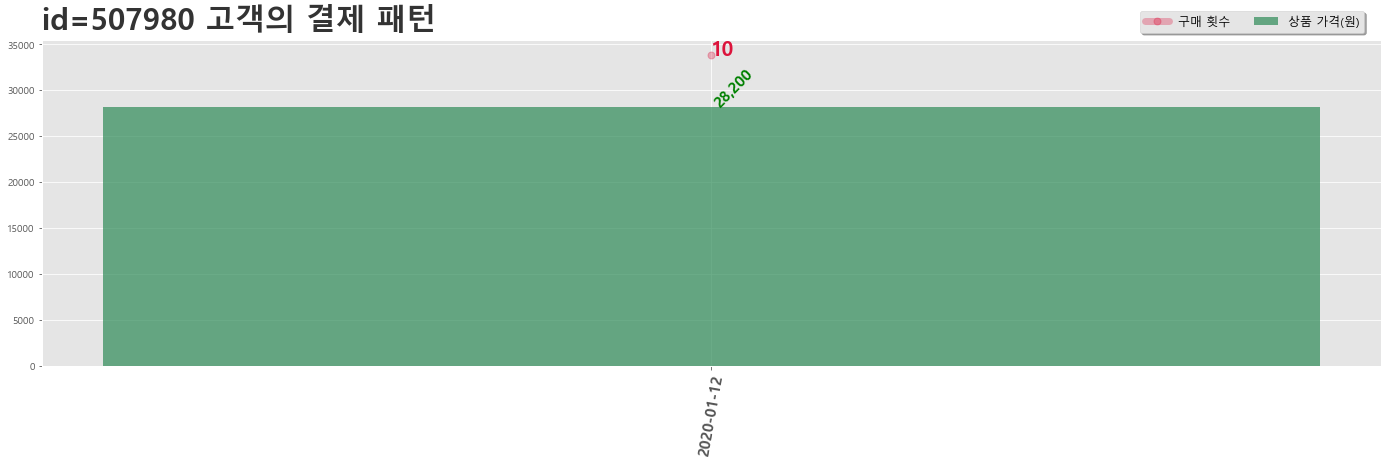

In [14]:
### 반복결제 평균값 상위 20명
for i in case2:
    patt(i)

In [15]:
cost = 28200
print(len(df1.loc[df1.pre==cost,'cnt_b']))

10267


In [16]:
case_93500 = []
for i in range(1,22):
    case_93500.append(i*93500)

for i in case_93500:
    print(f"{i:,} 원짜리 상품 판매 갯수 ---> {len(df1.loc[df1.pre==i,'cnt_b']):,}")

93,500 원짜리 상품 판매 갯수 ---> 6,947
187,000 원짜리 상품 판매 갯수 ---> 1,196
280,500 원짜리 상품 판매 갯수 ---> 1,013
374,000 원짜리 상품 판매 갯수 ---> 445
467,500 원짜리 상품 판매 갯수 ---> 1,579
561,000 원짜리 상품 판매 갯수 ---> 208
654,500 원짜리 상품 판매 갯수 ---> 168
748,000 원짜리 상품 판매 갯수 ---> 162
841,500 원짜리 상품 판매 갯수 ---> 269
935,000 원짜리 상품 판매 갯수 ---> 6,441
1,028,500 원짜리 상품 판매 갯수 ---> 0
1,122,000 원짜리 상품 판매 갯수 ---> 0
1,215,500 원짜리 상품 판매 갯수 ---> 0
1,309,000 원짜리 상품 판매 갯수 ---> 2
1,402,500 원짜리 상품 판매 갯수 ---> 0
1,496,000 원짜리 상품 판매 갯수 ---> 0
1,589,500 원짜리 상품 판매 갯수 ---> 0
1,683,000 원짜리 상품 판매 갯수 ---> 0
1,776,500 원짜리 상품 판매 갯수 ---> 0
1,870,000 원짜리 상품 판매 갯수 ---> 0
1,963,500 원짜리 상품 판매 갯수 ---> 0


### 2_사재기 유발 상품 규명

In [17]:
### 제일 많이 팔리는 상품가
data = df1[["pre","cnt_b"]].groupby("pre").sum()
data = data.sort_values(by="cnt_b",ascending=False).reset_index()

print(data.shape)
data.head(5)

(69956, 2)


,pre,cnt_b
0,9900,161414
1,5900,90899
2,8910,88127
3,7900,81148
4,4900,71423


27


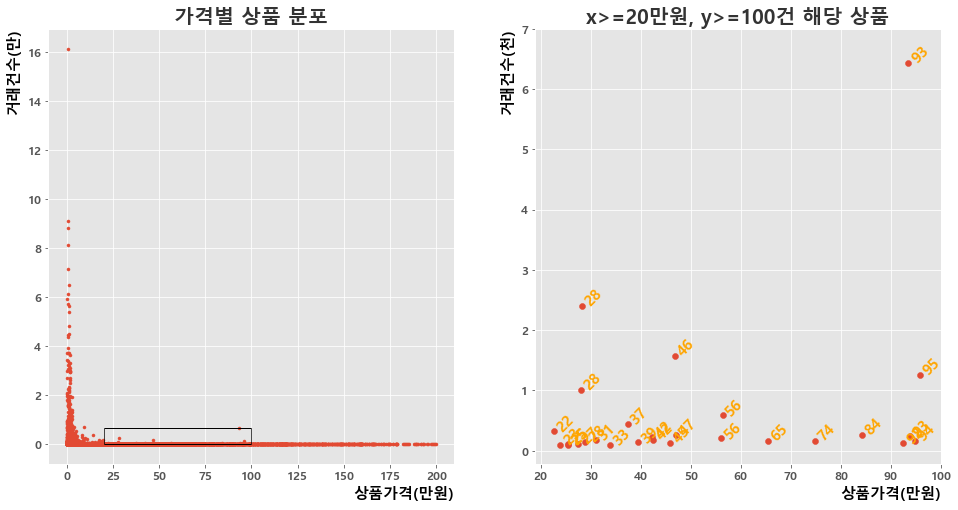

In [18]:
### 차트1) 전체 data
x1, y1 = data.pre, data.cnt_b

### 차트2) 25만원 이상 상품, 판매량 100건 이상
data_focus = data.loc[ (data.pre>=200000) & (data.cnt_b>=100) ]
data_focus = data_focus.reset_index(drop=True)
x2, y2 = data_focus.pre, data_focus.cnt_b
x_ex = [i//10000 for i in x2]
print(len(data_focus))

### 그리기
plt.figure(figsize=((16,8)))
plt.subplot(1,2,1)
plt.scatter(x1,y1, s=3**2)
x_name = range(0,2200000,250000)
plt.xticks(x_name,[i for i in range(0,225,25)], size=12, rotation=0, weight=1000, )
y_name = range(0,200000,20000)
plt.yticks(y_name,[i for i in range(0,20,2)], size=12, rotation=0, weight=1000, )
plt.xlabel("상품가격(만원)", weight=1000, color="k", size=15, rotation=0, loc="right", )
plt.ylabel("거래건수(만)",   weight=1000, color="k", size=15, rotation=90, loc="top",   )
plt.hlines(100, 200000, 1000000, color='k', linestyle='solid', linewidth=1)
plt.hlines(6500, 200000, 1000000, color='k', linestyle='solid', linewidth=1)
plt.vlines(200000, 100, 6500, color='k', linestyle='-', linewidth=1, alpha=0.7)
plt.vlines(1000000, 100, 6500, color='k', linestyle='-', linewidth=1, alpha=0.7)
plt.title("가격별 상품 분포", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )

plt.subplot(1,2,2)
plt.scatter(x2,y2)
plt.title("x>=20만원, y>=100건 해당 상품", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )
N = len(data_focus)
[plt.text(x2[i],y2[i],x_ex[i], size=15, color="orange", weight=1000, rotation=45) for i in range(N)]
x_name = range(200000,1100000,100000)
plt.xticks(x_name,[i for i in range(20,110,10)], size=12, rotation=0, weight=1000, )
y_name = range(0,8000,1000)
plt.yticks(y_name,[i for i in range(0,8,1)], size=12, rotation=0, weight=1000, )
plt.xlabel("상품가격(만원)", weight=1000, color="k", size=15, rotation=0, loc="right", )
plt.ylabel("거래건수(천)",   weight=1000, color="k", size=15, rotation=90, loc="top",   )
plt.show()

In [19]:
### 100건 이상 많이 팔리는 20만원 이상 고가 상품 ---> 27종
case = set(data_focus.pre)
print(len(case))

27


In [20]:
### 93,500 배수 금액 리스트 ----> 8개
A = set([93500*i for i in range(1,22)])
case & A

{280500, 374000, 467500, 561000, 654500, 748000, 841500, 935000}

In [21]:
### 28,200 배수 금액 리스트 ----> 9개
B = set([28200*i for i in range(1,71)])
case & B

{225600, 253800, 282000, 310200, 338400, 394800, 423000, 564000, 958800}

In [22]:
### 인기상품중 93,500 / 28,200 관계없는 금액들
C = sorted((case-A)-B)
print(len(C), C)

10 [239000, 255000, 275400, 289000, 425000, 459000, 470000, 925000, 938400, 948600]


In [23]:
### 배수관계 있는지 최소공배수 확인
from math import gcd

for i in C:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in C])

['     0', '  1000', '   200', '  1000', '  1000', '  1000', '  1000', '  1000', '   200', '   200']
['  1000', '     0', ' 10200', ' 17000', ' 85000', ' 51000', '  5000', '  5000', ' 10200', ' 10200']
['   200', ' 10200', '     0', '  3400', '  3400', ' 91800', '   200', '   200', ' 10200', ' 30600']
['  1000', ' 17000', '  3400', '     0', ' 17000', ' 17000', '  1000', '  1000', '  3400', '  3400']
['  1000', ' 85000', '  3400', ' 17000', '     0', ' 17000', '  5000', ' 25000', '  3400', '  3400']
['  1000', ' 51000', ' 91800', ' 17000', ' 17000', '     0', '  1000', '  1000', ' 10200', ' 30600']
['  1000', '  5000', '   200', '  1000', '  5000', '  1000', '     0', '  5000', '   400', '   200']
['  1000', '  5000', '   200', '  1000', ' 25000', '  1000', '  5000', '     0', '   200', '   200']
['   200', ' 10200', ' 10200', '  3400', '  3400', ' 10200', '   400', '   200', '     0', ' 10200']
['   200', ' 10200', ' 30600', '  3400', '  3400', ' 30600', '   200', '   200', ' 10200', 

In [24]:
candi = [10200, 17000]

for i in candi:
    result = set(C) & set([i*k for k in range(1,101)])
    print(f"{i:,} 금액의 배수중 C집합에 있는 상품수: {len(result)}개 --> {sorted(result)}")

10,200 금액의 배수중 C집합에 있는 상품수: 5개 --> [255000, 275400, 459000, 938400, 948600]
17,000 금액의 배수중 C집합에 있는 상품수: 4개 --> [255000, 289000, 425000, 459000]


In [25]:
candi = [93500, 28200, 10200, 17000]
R = case

for i in candi:
    result = case & set([i*k for k in range(1,101)])
    print(f"{i:,} 금액의 배수중 C집합에 있는 상품수: {len(result)}개 ---> {sorted(result)}")
    R = R-result

print(f"\n사재기 인기상품 case 27 종류 중, {len(R)}개 남음 -------> {sorted(R)}")

93,500 금액의 배수중 C집합에 있는 상품수: 8개 ---> [280500, 374000, 467500, 561000, 654500, 748000, 841500, 935000]
28,200 금액의 배수중 C집합에 있는 상품수: 9개 ---> [225600, 253800, 282000, 310200, 338400, 394800, 423000, 564000, 958800]
10,200 금액의 배수중 C집합에 있는 상품수: 7개 ---> [255000, 275400, 459000, 561000, 938400, 948600, 958800]
17,000 금액의 배수중 C집합에 있는 상품수: 8개 ---> [255000, 289000, 374000, 425000, 459000, 561000, 748000, 935000]

사재기 인기상품 case 27 종류 중, 3개 남음 -------> [239000, 470000, 925000]


In [26]:
### 배수관계 있는지 최소공배수 확인
for i in candi:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in candi])

['     0', '   100', '  1700', '  8500']
['   100', '     0', '   600', '   200']
['  1700', '   600', '     0', '  3400']
['  8500', '   200', '  3400', '     0']


In [27]:
### 배수관계 있는지 최소공배수 확인
R = [239000, 470000, 925000]

for i in R:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in R])

['     0', '  1000', '  1000']
['  1000', '     0', '  5000']
['  1000', '  5000', '     0']


In [28]:
data_focus["Q_93500"] = data_focus["pre"].apply(lambda x: f"{x//93500}" if x%93500==0 else ".")
data_focus["Q_28200"] = data_focus["pre"].apply(lambda x: f"{x//28200}" if x%28200==0 else ".")
data_focus["Q_10200"] = data_focus["pre"].apply(lambda x: f"{x//10200}" if x%10200==0 else ".")
data_focus["Q_17000"] = data_focus["pre"].apply(lambda x: f"{x//17000}" if x%17000==0 else ".")
data_focus = data_focus.reset_index(drop=True)
data_focus

,pre,cnt_b,Q_93500,Q_28200,Q_10200,Q_17000
0,935000,6441,10,.,.,55
1,282000,2405,.,10,.,.
2,467500,1579,5,.,.,.
3,958800,1263,.,34,94,.
4,280500,1013,3,.,.,.
5,564000,588,.,20,.,.
6,374000,445,4,.,.,22
7,225600,319,.,8,.,.
8,841500,269,9,.,.,.
9,470000,253,.,.,.,.


In [29]:
### 씨앗상품 들의 단품 판매 건수도 많은가?
lst = [93500,28200,10200,17000,187000]

for i in lst:
    print( i, "--->", len(df1.loc[df1.pre==i]))

93500 ---> 6947
28200 ---> 10267
10200 ---> 2680
17000 ---> 5399
187000 ---> 1196


In [30]:
### 보따리 상품 27종 구매한 사람 체킹
df1["case27"] = df1.pre.apply(lambda x:1 if x in case else 0)
temp = df1[["id","case27"]].groupby("id").max().reset_index()
df3 = pd.merge( df3, temp, how="left", on="id" )
df3

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.00,0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.00,0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.00,0
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,2019-07-27,227640,216980,0,10660,10660,0.0,4.7,4.7,1,8,1,1.00,0
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,2020-01-11,65170,55170,0,10000,10000,0.0,15.3,15.3,1,6,1,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544916,544917,27,0,0,0,1994-07-08,2019-08-11 01:56:44.713,2019-08-11,41220,34740,0,6480,6480,0.0,15.7,15.7,1,2,1,1.00,0
544917,544918,23,0,1,0,1998-02-26,2019-12-08 12:28:08.093,2019-12-08,268665,252665,2296,16000,18296,0.9,6.0,6.8,1,21,1,1.00,0
544918,544919,41,0,1,0,1980-03-25,2019-08-03 16:06:57.300,2019-08-03,529022,483123,177,45899,46076,0.0,8.7,8.7,1,43,3,1.13,0
544919,544920,49,1,1,0,1972-02-07,2019-08-31 11:02:08.238,2019-08-31,462100,429100,441,33000,33441,0.1,7.1,7.2,1,7,1,1.00,0


### 3_보따리상 특성 추정

In [31]:
### 전체 유저 특성
df300 = df3[['age', 'man', 'push', 'frgn', 'sign_cut', 'pre', 'post', 'c_back', 'dscnt', 'total', 'cnt_b', 'RP_max', 'RP_mean', 'case27']]
infox(   df300   )

◆◆◆ (544921, 14): Total shape ◆◆◆
---(544921, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype   n_uniq  |     Mean      Std    |max-min|  │  min      Q1  median       Q3          max  
 0      age     0      0.0    int64       83  |    36.83    11.58          106  │   15      29      36       42          121  
 1      man     0      0.0    int64        2  |   0.3587   0.4796            1  │    0       0       0        1            1  
 2     push     0      0.0    int64        2  |   0.4186   0.4933            1  │    0       0       0        1            1  
 3     frgn     0      0.0    int64        2  |   0.0058   0.0757            1  │    0       0       0        0            1  
 4      pre     0      0.0    int64  168,111  |  211,107  550,002  115,004,850  │  500  23,800  67,300  206,356  115,005,350  
 5     post     0      0.0    int64  176,425  |  196,438  527,835  112,273,800  │    0  20,140  60,480  191,024  112,273,800

In [32]:
### 보따리 상품 1번이라도 산 사람 -----------> 셋중 둘 남자, 알람 싫은편, 고가 상품 선호(보따리.. 당연), 대부분 반복구매 관심 없다
### (20만원이상 고가이면서, 잘 팔리는 제품)
infox(   df300.loc[df300.case27==1]   )

◆◆◆ (9484, 14): Total shape ◆◆◆
---(9484, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean        Std    |max-min|  │      min       Q1   median         Q3          max  
 0      age     0      0.0    int64      71  |        38.      10.94          105  │       16       32       37         42          121  
 1      man     0      0.0    int64       2  |     0.6827     0.4654            1  │        0        0        1          1            1  
 2     push     0      0.0    int64       2  |     0.3128     0.4637            1  │        0        0        0          1            1  
 3     frgn     0      0.0    int64       2  |     0.0018     0.0423            1  │        0        0        0          0            1  
 4      pre     0      0.0    int64   6,613  |  1,451,941  2,834,105  114,779,750  │  225,600  467,500  935,000  1,589,500  115,005,350  
 5     post     0      0.0    int64   6,753  |  1,396,467  2,7

In [33]:
### 한상품을 하루에 20번 살만큼 꽂힌 경험있는 유저 ----> 알람 좋아하는 외국인, 거래건수 정말 많고, 따라서 매출도 높다
infox(   df300.loc[df300.RP_max>20]   )

◆◆◆ (19, 14): Total shape ◆◆◆
---(19, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean        Std   |max-min|  │     min         Q1     median         Q3         max  
 0      age     0      0.0    int64      13  |      36.11      6.189          23  │      28       30.5         37         40          51  
 1      man     0      0.0    int64       2  |     0.5789     0.4937           1  │       0          0          1          1           1  
 2     push     0      0.0    int64       2  |     0.6842     0.4648           1  │       0          0          1          1           1  
 3     frgn     0      0.0    int64       2  |     0.1053     0.3069           1  │       0          0          0          0           1  
 4      pre     0      0.0    int64      19  |  6,857,100  7,650,594  27,107,493  │  79,030  1,267,148  3,114,802  7,419,090  27,186,523  
 5     post     0      0.0    int64      19  |  6,721,667  7

In [34]:
### 거래 횟수가 많은 집단 ---> 여성, 알람 좋아, 셋중 하나 외국인, 보따리상 상품 관심없음
infox(   df300.loc[df300.cnt_b>425]   )

◆◆◆ (20, 14): Total shape ◆◆◆
---(20, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean        Std   |max-min|  │        min         Q1      median          Q3         max  
 0      age     0      0.0    int64      14  |       33.95      6.852          24  │         25      28.75        31.5       37.75          49  
 1      man     0      0.0    int64       2  |        0.05     0.2179           1  │          0          0           0           0           1  
 2     push     0      0.0    int64       2  |        0.85     0.3571           1  │          0          1           1           1           1  
 3     frgn     0      0.0    int64       2  |        0.35      0.477           1  │          0          0           0           1           1  
 4      pre     0      0.0    int64      20  |  13,890,351  8,950,243  32,021,674  │  3,022,112  6,480,086  12,993,109  19,395,920  35,043,786  
 5     post     0      0

In [35]:
### 거래 횟수가 많은 최상위 집단 ---> 젊은 여성, 알람 좋아, 절반은 외국인, 보따리상 상품 관심없음
infox(   df300.loc[df300.cnt_b>500]   )

◆◆◆ (10, 14): Total shape ◆◆◆
---(10, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean        Std   |max-min|  │         min          Q1      median          Q3         max  
 0      age     0      0.0    int64       7  |        29.7       2.61          10  │          25          28        29.5          31          35  
 1      man     0      0.0    int64       1  |           0          0           0  │           0           0           0           0           0  
 2     push     0      0.0    int64       1  |           1          0           0  │           1           1           1           1           1  
 3     frgn     0      0.0    int64       2  |         0.5        0.5           1  │           0           0         0.5           1           1  
 4      pre     0      0.0    int64      10  |  21,304,483  6,650,189  21,537,805  │  13,505,981  15,660,912  20,282,792  25,972,130  35,043,786  
 5     post 

In [36]:
### 거래 패턴이 주로 반복구매인 유저 ---> 주로 남성 내국인, 알람설정 싫고, 고가 상품에 관심 많다
infox(   df300.loc[df300.RP_mean>5]   )

◆◆◆ (69, 14): Total shape ◆◆◆
---(69, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean         Std    |max-min|  │     min       Q1   median         Q3          max  
 0      age     0      0.0    int64      30  |      38.75       11.02           66  │      21       33       38         43           87  
 1      man     0      0.0    int64       2  |     0.6812       0.466            1  │       0        0        1          1            1  
 2     push     0      0.0    int64       2  |     0.3043      0.4601            1  │       0        0        0          1            1  
 3     frgn     0      0.0    int64       1  |          0           0            0  │       0        0        0          0            0  
 4      pre     0      0.0    int64      48  |  5,785,385  18,036,253  110,423,100  │  21,000  253,800  935,000  1,466,000  110,444,100  
 5     post     0      0.0    int64      52  |  5,646,014  17,656,

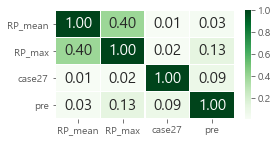

In [37]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(4, 2))
sns.heatmap(  df300[["RP_mean","RP_max","case27","pre"]].corr()**2, cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

In [38]:
### 거래 횟수가 많은 집단 ---> 평균나이40, 셋중 2명 남성, 보따리상 상품 관심 매우 많음
infox(   df300.loc[df300.pre>10000000]   )

◆◆◆ (112, 14): Total shape ◆◆◆
---(112, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean         Std    |max-min|  │         min          Q1      median          Q3          max  
 0      age     0      0.0    int64      40  |       40.51       10.22           51  │          25          34          39          45           76  
 1      man     0      0.0    int64       2  |       0.625      0.4841            1  │           0           0           1           1            1  
 2     push     0      0.0    int64       2  |      0.4643      0.4987            1  │           0           0           0           1            1  
 3     frgn     0      0.0    int64       2  |      0.0536      0.2252            1  │           0           0           0           0            1  
 4      pre     0      0.0    int64     112  |  19,753,075  15,907,173  104,724,350  │  10,281,000  12,338,850  15,026,631  20,245,457  115,00

# 2_군집별 특성 출력하는 시각화 함수

In [39]:
df3.head()

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0,0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.0,0
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,2019-07-27,227640,216980,0,10660,10660,0.0,4.7,4.7,1,8,1,1.0,0
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,2020-01-11,65170,55170,0,10000,10000,0.0,15.3,15.3,1,6,1,1.0,0


In [40]:
display(df3.head(1))

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0


In [41]:
df3.columns

Index(['id', 'age', 'man', 'push', 'frgn', 'birth', 'sign', 'sign_cut', 'pre',
       'post', 'c_back', 'dscnt', 'total', 'c_back_R', 'dscnt_R', 'total_R',
       'cnt_p', 'cnt_b', 'RP_max', 'RP_mean', 'case27'],
      dtype='object')

In [42]:
### 개인별 데이터 --->  df2, df3 의 일부를 슬라이싱 하여 넣으면.. (특정 유저들)
def anal(df):

   data = df[['id','age','man','push','frgn','pre','c_back','dscnt','total','cnt_p','cnt_b',]]
   data["idx"] = "all"
   data = data.groupby("idx").sum()
   # for i in ['age','man','push','frgn','pre','c_back','dscnt','total','cnt_b',]:
   #    data[i] = data[i]/data["age"]



   return data

anal(df3)

    #나이, 나이 분포, ------------------> 전체도 같이 대비
    #남성 비중, 알람 비중, 외국인 비중 -------> 전체도 같이 대비 (파이차트)



,id,age,man,push,frgn,pre,c_back,dscnt,total,cnt_p,cnt_b
idx,,,,,,,,,,,
all,148469720581,20072009,195439,228121,3141,115036891079,689866071,7993568844,8683434915,544921,5623810


# 3_feature별 categorical --> grid search

### 전처리1_매출가 대신 순매출가도 고려
- 안쓰이는 post = pre - dscnt 피쳐를 버리지 말고
- 순매출 post = pre - total = pre - (dscnt + cashback) 으로 놓고 활용

In [43]:
### 유저별 구매력 기준을 ---> 모든 혜택을 제외한 순매출가로 측정
df1["post"] = df1["pre"] - df1["total"]
df3["post"] = df3["pre"] - df3["total"]
display(df1.head(1))
display(df3.head(1))
infox(df3[["pre","post"]])

,id,age,man,push,frgn,birth,sign,buy,buy_cut,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_b,case27
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,2019-08-01,9,43000,35000,0,8000,8000,0.0,18.6,18.6,1,0


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0


◆◆◆ (544921, 2): Total shape ◆◆◆
---(544921, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype   n_uniq  |     Mean      Std    |max-min|  │  min      Q1  median       Q3          max  
 0     pre     0      0.0  int64  168,111  |  211,107  550,002  115,004,850  │  500  23,800  67,300  206,356  115,005,350  
 1    post     0      0.0  int64  217,071  |  195,172  525,590  112,273,800  │    0  20,019  60,120  190,050  112,273,800  
------------------------------------------------------------------------------ 



### 전처리2_전액 무료 구매자 data 배제
- 전액 무료혜택자 1,366 명(0.25%)이 단 1건의 구매를 통해서 영업이익 0%의 매출 700만원을 달성
- 엄밀한 의미에서 고객이라고 하기 힘들다 (영업이익 발생 zero)
- 그룹핑에 따라 그룹내 인원수가 작으며 1,366 명이 쏠릴경우, 평균시 분모의 카운트만 높여서 의미를 해칠 우려

In [44]:
### 자기돈 안 들이고 100% 공짜 구매만 한 사람
df3.loc[df3.post==0]

### ----> 2번 이상 구매자 없음
# df3.loc[ (df3.post==0) & (df3.cnt_b>1) ]

### ----> 합산 대략 700만원 정도 미끼만 섭취
# df3.loc[df3.post==0].groupby("cnt_p").sum()

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
425,426,56,0,1,0,1965-01-22,2019-08-01 10:46:35.432,2019-08-01,8000,0,0,8000,8000,0.0,100.0,100.0,1,1,1,1.0,0
1275,1276,51,1,0,0,1970-02-20,2019-12-20 11:58:44.509,2019-12-20,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
1418,1419,40,1,1,0,1981-04-19,2019-08-01 18:26:08.988,2019-08-01,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
1647,1648,121,1,0,0,1900-01-01,2019-06-24 01:38:08.865,2019-06-24,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
1946,1947,30,0,0,0,1991-01-08,2019-08-01 22:37:56.135,2019-08-01,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543383,543384,23,1,1,0,1998-04-13,2019-08-01 19:04:59.095,2019-08-01,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
543545,543546,23,0,1,0,1998-05-12,2019-11-07 13:27:15.918,2019-11-07,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
543622,543623,66,1,1,0,1955-12-10,2019-11-25 21:07:23.790,2019-11-25,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0
544211,544212,30,0,0,0,1991-03-26,2019-10-14 23:17:25.830,2019-10-14,5000,0,0,5000,5000,0.0,100.0,100.0,1,1,1,1.0,0


In [45]:
""" 100% 공짜 먹튀 유저 배제 """
drop_index = df3.loc[ df3.post==0 ].index
print(len(drop_index))
df3 = df3.drop(drop_index)
display(df3.head(2))
print(df3.shape)

1366


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0,0


(543555, 21)


In [46]:
### 새로운 id 배정 ---> 순매출(post) 기준 내림차순(등수)

df3 = df3.sort_values(by="post",ascending=False).reset_index(drop=True).reset_index()
df3 = df3.rename(columns={"index":"new_id"})
df3["new_id"] = df3["new_id"]+1

print(df3.shape)
display(df3.head(3))
display(df3.tail(2))

df3 = df3.sort_values(by="id").reset_index(drop=True) ## 정렬 ---> 다시 id 순 복구
display(df3.head(2))

(543555, 22)


,new_id,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,377381,48,1,1,0,1973-08-22,2019-08-02 20:41:51.412,2019-08-02,115005350,112273800,0,2731550,2731550,0.0,2.4,2.4,1,175,11,5.00,1
1,2,94844,37,1,1,0,1984-03-10,2020-01-06 00:29:47.110,2020-01-06,110444100,108245507,150093,2048500,2198593,0.1,1.9,2.0,1,133,11,9.50,1
2,3,38481,49,1,1,0,1972-03-13,2019-10-21 19:33:08.665,2019-10-21,76952000,75176900,0,1775100,1775100,0.0,2.3,2.3,1,83,13,6.38,1


,new_id,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
543553,543554,200122,34,1,0,0,1987-11-27,2019-10-17 03:48:18.888,2019-10-17,5010,10,0,5000,5000,0.0,99.8,99.8,1,1,1,1.0,0
543554,543555,180853,22,0,0,0,1999-05-20,2019-10-01 18:55:29.531,2019-10-01,5010,10,0,5000,5000,0.0,99.8,99.8,1,1,1,1.0,0


,new_id,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,414940,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0
1,413317,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0,0


### 1_독립변수 범주화(category)

In [49]:
### personal data: df9 변수명 이용

df9 = df3[['id', 'new_id', 'age', 'man', 'push', 'frgn', 'pre', 'post', 'c_back', 'dscnt', 'total', 'cnt_p', 'cnt_b', 'RP_max', 'RP_mean', 'case27']]
display(df9.head(2))
infox( df9 )

,id,new_id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,414940,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0
1,2,413317,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0


◆◆◆ (543555, 16): Total shape ◆◆◆
---(543555, 16): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype   n_uniq  |     Mean      Std    |max-min|  │  min       Q1   median       Q3          max  
 0       id     0      0.0    int64  543,555  |  272,454  157,308      544,920  │    1  136,221  272,465  408,684      544,921  
 1   new_id     0      0.0    int64  543,555  |  271,778  156,910      543,554  │    1  135,889  271,778  407,666      543,555  
 2      age     0      0.0    int64       83  |     36.8    11.48          106  │   15       29       36       42          121  
 3      man     0      0.0    int64        2  |   0.3582   0.4795            1  │    0        0        0        1            1  
 4     push     0      0.0    int64        2  |    0.419   0.4934            1  │    0        0        0        1            1  
 5     frgn     0      0.0    int64        2  |   0.0058   0.0758            1  │    0        0        0        

In [52]:
""" 1) 나이: 5년 기준 -----> 30대 초반, 30대 후반 """

df9["1_age"] = (df9["age"]//5)*5

display(df9.head(2))
infox( df9[["age","1_age"]] ) #---- 5년 간격 19개 계급
df9.1_age.value_counts()

,id,new_id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27,1_age
0,1,414940,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0,35
1,2,413317,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0,25


◆◆◆ (543555, 2): Total shape ◆◆◆
---(543555, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype  n_uniq  |   Mean    Std  |max-min|  │  min  Q1  median  Q3  max  
 0     age     0      0.0  int64      83  |   36.8  11.48        106  │   15  29      36  42  121  
 1   1_age     0      0.0  int64      19  |  34.81  11.61        105  │   15  25      35  40  120  
------------------------------------------------------------------------------ 



In [54]:
""" 2) 남성여부, 알람여부, 외국인여부: 그대로 2분할 """

df9 = df9.rename(columns={"man":"2_man","push":"3_push","frgn":"4_frgn"})

display(df9.head(2))
infox( df9[["2_man","3_push","4_frgn"]] )

,id,new_id,age,2_man,3_push,4_frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27,1_age
0,1,414940,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0,35
1,2,413317,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0,25


◆◆◆ (543555, 3): Total shape ◆◆◆
---(543555, 3): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype  n_uniq  |    Mean     Std  |max-min|  │  min  Q1  median  Q3  max  
 0   2_man     0      0.0  int64       2  |  0.3582  0.4795          1  │    0   0       0   1    1  
 1  3_push     0      0.0  int64       2  |   0.419  0.4934          1  │    0   0       0   1    1  
 2  4_frgn     0      0.0  int64       2  |  0.0058  0.0758          1  │    0   0       0   0    1  
------------------------------------------------------------------------------ 

